
# Kalshi Sports — Open vs Close Regimes (From Scratch)

This notebook **does everything from scratch**:

1. Discover sports series (or use a curated list)
2. Pull **settled markets** for a date range
3. For each settled market, pull **candlesticks** to get:
   - **Opening price** (first candle in lookback window)
   - **Closing price** (last candle before close)
4. Build a contract-level dataset
5. Analyze open/close behavior under two easy regimes:
   - **High vs Low Drift days** (information-flow regime)
   - **Upset-heavy vs Favorite-dominant days** (outcome regime)

No PCA required; works well even when data is sparse.

---

## Setup required

You need Kalshi API auth available **either** via environment variable:

- `KALSHI_AUTH` (example: `Bearer <token>`)  
- optionally `KALSHI_BASE_URL` (defaults to the common v2 base URL)

If your auth scheme is different, edit the `HEADERS` cell below.


In [1]:

import os
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import json

pd.set_option("display.max_columns", 200)


## API config

In [2]:

BASE_URL = os.environ.get("KALSHI_BASE_URL", "https://api.elections.kalshi.com/trade-api/v2")

HEADERS = {}


# Polite rate limiting
SLEEP_BETWEEN_CALLS = 0.05

print("BASE_URL:", BASE_URL)


BASE_URL: https://api.elections.kalshi.com/trade-api/v2



## Request helper (handles 429 retries)

Kalshi rate limits can trigger 429s. This wrapper retries with exponential backoff.


In [3]:
# HTTP helper with connection pooling + friendlier rate-limit handling
import random
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

_session = requests.Session()
_adapter = HTTPAdapter(
    pool_connections=50,
    pool_maxsize=50,
    max_retries=Retry(
        total=0,  # we do our own retry/backoff for 429 and non-200
        connect=0,
        read=0,
        redirect=0,
        status=0,
    ),
)
_session.mount("https://", _adapter)
_session.mount("http://", _adapter)

def kalshi_get(url, params=None, max_retries=4, timeout=(5, 25)):
    """GET JSON with:
    - connection pooling (Session)
    - bounded retries
    - 429 backoff using Retry-After when available
    - jitter to avoid thundering herd
    """
    for attempt in range(max_retries):
        r = _session.get(url, params=params, headers=HEADERS, timeout=timeout)
        if r.status_code == 429:
            retry_after = r.headers.get("Retry-After")
            if retry_after is not None:
                try:
                    wait = float(retry_after)
                except Exception:
                    wait = 1.0
            else:
                wait = min(8.0, 1.5 * (2 ** attempt))
            wait = wait * (0.7 + 0.6 * random.random())  # jitter 0.7–1.3x
            # Keep this quiet; noisy prints + threads = slow. Uncomment if debugging.
            # print(f"429 rate limited, waiting {wait:.1f}s...")
            time.sleep(wait)
            continue

        if r.status_code != 200:
            # Small backoff on transient errors
            if r.status_code in (500, 502, 503, 504) and attempt < max_retries - 1:
                time.sleep(min(4.0, 0.5 * (2 ** attempt)))
                continue
            raise RuntimeError(f"HTTP {r.status_code}: {r.text[:400]}")
        return r.json()

    raise RuntimeError("Too many retries (rate limited / transient errors).")




## Step 1 — Discover series and select sports series

You can either:
- Use the curated list in `SPORTS_SERIES`, or
- Print all Sports series and manually choose.


In [4]:

def get_all_series():
    out=[]
    cursor=None
    while True:
        params={"limit":200, "include_volume":True}
        if cursor:
            params["cursor"]=cursor
        data=kalshi_get(f"{BASE_URL}/series", params=params)
        series_list=data.get("series", [])
        if not series_list:
            break
        out.extend(series_list)
        cursor=data.get("cursor")
        if not cursor:
            break
        time.sleep(SLEEP_BETWEEN_CALLS)
    return pd.DataFrame(out)

series_df = get_all_series()
print("Total series:", len(series_df))

sports_df = series_df[series_df.get("category")=="Sports"].copy()
print("Sports series:", len(sports_df))
sports_df[["ticker","title","volume"]].sort_values("volume", ascending=False).head(25)


Total series: 8636
Sports series: 1372


,ticker,title,volume
3996,KXNBAGAME,Professional Basketball Game,5804254364
876,KXNFLGAME,Professional Football Game,5247129252
2902,KXNCAAFGAME,College Football Game,4020814717
2561,KXNCAAMBGAME,Men's College Basketball Men's Game,3483464823
1498,KXATPMATCH,ATP Tennis Match,1127181026
8491,KXMLBGAME,Professional Baseball Game,865058318
890,KXNHLGAME,NHL Game,809288081
8521,KXNFLSPREAD,Pro Football Spread,770498839
2657,KXWTAMATCH,WTA Tennis Match,740325328
5988,KXATPCHALLENGERMATCH,Challenger ATP,550430434


In [5]:

# Curated set of game-level sports series (edit as needed)
SPORTS_SERIES = [
    "KXNBAGAME",      # NBA
    "KXNFLGAME",      # NFL
    "KXNHLGAME",      # NHL
    "KXMLBGAME",      # MLB
]

available = set(series_df["ticker"].astype(str).tolist())
TARGET_SERIES = [t for t in SPORTS_SERIES if t in available]
missing = [t for t in SPORTS_SERIES if t not in available]

print("TARGET_SERIES:", TARGET_SERIES)
if missing:
    print("Missing series (not found):", missing)


TARGET_SERIES: ['KXNBAGAME', 'KXNFLGAME', 'KXNHLGAME', 'KXMLBGAME']



## Step 2 — Pull settled markets for a date range

We query `/markets` with:
- `series_ticker`
- `status=settled`
- `min_close_ts`, `max_close_ts`

Tip: start with a narrower range to keep API calls manageable.


In [6]:

# Date range (UTC)
MIN_CLOSE_DATE = "2025-08-01"
MAX_CLOSE_DATE = "2025-12-01"

min_close_ts = int(pd.to_datetime(MIN_CLOSE_DATE, utc=True).timestamp())
max_close_ts = int(pd.to_datetime(MAX_CLOSE_DATE, utc=True).timestamp())

print("Close window:", MIN_CLOSE_DATE, "to", MAX_CLOSE_DATE)


Close window: 2025-08-01 to 2025-12-01


In [7]:

def get_settled_markets_for_series(series_ticker, min_close_ts, max_close_ts):
    all_markets = []
    cursor = None
    while True:
        params = {
            "series_ticker": series_ticker,
            "status": "settled",
            "min_close_ts": min_close_ts,
            "max_close_ts": max_close_ts,
            "limit": 1000
        }
        if cursor:
            params["cursor"] = cursor

        data = kalshi_get(f"{BASE_URL}/markets", params=params)
        # Defensive: If API returned no data or not a dict, treat as empty
        if not isinstance(data, dict):
            print(f"Warning: Unexpected market API response for {series_ticker}. Skipping.")
            break
        mkts = data.get("markets", [])
        if not isinstance(mkts, list):
            mkts = []
        all_markets.extend(mkts)

        cursor = data.get("cursor")
        if not cursor:
            break
        # Defensive: throttle, but allow SLEEP_BETWEEN_CALLS to be optional
        try:
            time.sleep(SLEEP_BETWEEN_CALLS)
        except Exception:
            time.sleep(1)
    return all_markets

# Pull markets (cached to disk to avoid re-pulling)
CACHE_DIR = "kalshi_cache"
os.makedirs(CACHE_DIR, exist_ok=True)
markets_cache_path = os.path.join(CACHE_DIR, f"settled_markets_{MIN_CLOSE_DATE}_{MAX_CLOSE_DATE}.json")

markets_by_series = {}
cache_loaded = False

if os.path.exists(markets_cache_path):
    try:
        with open(markets_cache_path, "r", encoding="utf-8") as f:
            content = f.read().strip()
            if content:
                markets_by_series = json.loads(content)
                cache_loaded = True
                print("Loaded cached markets:", markets_cache_path)
            else:
                print("Cache file is empty; will fetch data anew.")
    except json.JSONDecodeError as e:
        print(f"Warning: Could not decode cache file ({markets_cache_path}). Re-fetching. ({e})")
    except Exception as e:
        print(f"Warning: Error reading cache file ({markets_cache_path}). Re-fetching. ({e})")

if not cache_loaded:
    for s in TARGET_SERIES:
        mkts = get_settled_markets_for_series(s, min_close_ts, max_close_ts)
        markets_by_series[s] = mkts
        print(f"{s}: {len(mkts)} settled markets")
    # Safely write JSON (ensure not interrupted, avoid partial writes)
    try:
        with open(markets_cache_path, "w", encoding="utf-8") as f:
            json.dump(markets_by_series, f)
        print("Saved cache:", markets_cache_path)
    except Exception as e:
        print(f"Warning: Failed to save cache to {markets_cache_path}: {e}")

# quick summary
summary = {s: len(mkts) for s, mkts in markets_by_series.items()}
pd.Series(summary).sort_values(ascending=False)


KXNBAGAME: 670 settled markets
KXNFLGAME: 478 settled markets
KXNHLGAME: 930 settled markets
KXMLBGAME: 1682 settled markets
Saved cache: kalshi_cache\settled_markets_2025-08-01_2025-12-01.json


KXMLBGAME    1682
KXNHLGAME     930
KXNBAGAME     670
KXNFLGAME     478
dtype: int64


## Step 3 — Candlesticks to get *opening* and *closing* price

We compute:
- `p_open` = first candlestick open (in a lookback window)
- `p_close` = last candlestick close up to close_time

We try:
1. live endpoint: `/series/{series}/markets/{ticker}/candlesticks`
2. fallback: `/historical/markets/{ticker}/candlesticks`

**Important:** You may need to adjust endpoints if your Kalshi environment differs.


In [10]:
# Efficiently extract open/close prices and build the contract-level dataset (optimized for DAILY markets)
# Key changes vs generic lookback:
#  - Candlestick window is bounded to the *same trading day* (New York time) instead of N days
#  - Optional small buffer before midnight ET to catch early trading
#  - Parallel candlestick fetches (I/O bound) via ThreadPoolExecutor
#  - O(1) open/close extraction (no per-market sorting)
#  - Vectorized feature engineering after DataFrame construction
#
# Fixes vs prior daily-optimized version:
#  - Robust close time parsing (supports close_ts unix seconds + ISO strings)
#  - More robust outcome extraction (supports several common settled-market fields)
#  - More robust candlestick endpoint fallback order
#  - More robust price parsing across possible candle schemas

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
import random

DAY_TZ = "America/New_York"

# Fetch candles from (midnight ET - buffer) up to the market's close time.
DAY_START_BUFFER_HOURS = 1  # small safety buffer (hours)

# Candlestick granularity in seconds (10m keeps payload small but still gives good open/close)
PERIOD_INTERVAL_MINUTES= 60  # 60 minutes (Kalshi API valid values: 1, 60, 1440)

# Tune based on your network and Kalshi rate limits.
MAX_WORKERS = 4  # start conservative; increase if you don't see 429s/timeouts


def _norm_str(v):
    return v.strip().upper() if isinstance(v, str) else None


def extract_binary_outcome(m: dict):
    """
    Best-effort extraction of a binary outcome for *settled* markets.

    Kalshi payloads differ by endpoint/version; this handles:
      - direct scalar fields: result/resolution/outcome/settlement_value (0/1 or YES/NO strings)
      - nested dicts: settlement: { outcome: "YES" } etc.
    """
    # 1) direct keys
    direct_keys = [
        "result", "resolution", "resolved_outcome", "settlement", "settlement_value",
        "outcome", "settled_outcome", "final_outcome", "resolved", "winning_outcome",
    ]
    for k in direct_keys:
        if k not in m:
            continue
        v = m.get(k)
        if isinstance(v, (int, float)) and v in (0, 1):
            return int(v)
        vv = _norm_str(v)
        if vv in ("YES", "Y", "TRUE", "T", "WIN", "W", "1"):
            return 1
        if vv in ("NO", "N", "FALSE", "F", "LOSE", "L", "0"):
            return 0
        # sometimes settlement is a dict
        if isinstance(v, dict):
            for kk in ("outcome", "result", "resolution", "winning_outcome", "value"):
                subv = v.get(kk)
                if isinstance(subv, (int, float)) and subv in (0, 1):
                    return int(subv)
                sv = _norm_str(subv)
                if sv in ("YES", "Y", "TRUE", "T", "WIN", "W", "1"):
                    return 1
                if sv in ("NO", "N", "FALSE", "F", "LOSE", "L", "0"):
                    return 0

    # 2) contracts array (some schemas encode settlement per contract)
    contracts = m.get("contracts")
    if isinstance(contracts, list) and contracts:
        # Try to find YES/NO contracts and a settled winner
        # Common fields: "ticker"/"name" == YES/NO and "result"/"won" flags.
        yes_won = None
        for c in contracts:
            if not isinstance(c, dict):
                continue
            label = _norm_str(c.get("ticker") or c.get("name") or c.get("label") or "")
            won = c.get("won") if "won" in c else c.get("result")
            if isinstance(won, (int, float)) and won in (0, 1):
                # if this contract is YES/NO we can interpret
                if label in ("YES", "Y"):
                    yes_won = int(won)
                if label in ("NO", "N") and yes_won is None:
                    # if NO won then YES lost
                    yes_won = 1 - int(won)
            sv = _norm_str(won)
            if sv in ("YES", "Y", "TRUE", "T", "WIN", "W", "1") and label in ("YES", "Y"):
                yes_won = 1
            if sv in ("YES", "Y", "TRUE", "T", "WIN", "W", "1") and label in ("NO", "N"):
                yes_won = 0
        if yes_won in (0, 1):
            return yes_won

    return None


def get_close_dt_utc(m: dict):
    """
    Robustly obtain close datetime in UTC.

    Supports common field variants:
      - close_ts / close_time_ts : unix seconds (int)
      - close_time : ISO timestamp (str)
    """
    for k in ("close_ts", "close_time_ts", "closeTimeTs", "closeTimestamp"):
        v = m.get(k)
        if isinstance(v, (int, float)) and v > 0:
            return pd.to_datetime(int(v), unit="s", utc=True)

    for k in ("close_time", "closeTime", "close_datetime", "closeDateTime"):
        v = m.get(k)
        if isinstance(v, str) and v.strip():
            dt = pd.to_datetime(v, utc=True, errors="coerce")
            if not pd.isna(dt):
                return dt

    return None


def _parse_price(v):
    """Normalize a price to [0,1] dollars when possible."""
    if v is None:
        return None
    if isinstance(v, str):
        try:
            v = float(v)
        except Exception:
            return None
    if not isinstance(v, (int, float)):
        return None
    # Typical Kalshi prices are in dollars 0..1; sometimes cents 0..100
    if v > 1.5 and v <= 100:
        return float(v) / 100.0
    return float(v)


def fetch_candlesticks(series_ticker: str, market_ticker: str, start_ts: int, end_ts: int, period_interval_minutes: int):
    """
    Fetch candlesticks for a market in [start_ts, end_ts].

    Endpoint availability varies by API version; try multiple routes.
    """
    params = {
        "start_ts": int(start_ts),
        "end_ts": int(end_ts),
        "period_interval": int(period_interval_minutes),
        "include_latest_before_start": False,
    }

    endpoints = [
        # Most direct
        f"{BASE_URL}/markets/{market_ticker}/candlesticks",
        # Series-scoped (older / alternate)
        f"{BASE_URL}/series/{series_ticker}/markets/{market_ticker}/candlesticks",
        # Historical fallback
        f"{BASE_URL}/historical/markets/{market_ticker}/candlesticks",
    ]

    last_err = None
    for url in endpoints:
        try:
            data = kalshi_get(url, params=params)
            c = data.get("candlesticks", [])
            if isinstance(c, list):
                return c
        except Exception as e:
            last_err = e
            continue

    # If all failed, surface the last error to help debugging
    if last_err is not None:
        raise last_err
    return []


def fast_open_close_from_candles(candles):
    """
    O(1) open+close extraction assuming API returns candles in chronological order.
    Robust to a few candle schema variants.
    """
    if not candles:
        return None, None

    def get_open(c):
        p = c.get("price") if isinstance(c, dict) else None
        if isinstance(p, dict):
            return _parse_price(p.get("open_dollars") or p.get("open") or p.get("open_price") or p.get("open_cents"))
        # sometimes price fields are top-level
        if isinstance(c, dict):
            return _parse_price(c.get("open_dollars") or c.get("open") or c.get("open_price") or c.get("open_cents"))
        return None

    def get_close(c):
        p = c.get("price") if isinstance(c, dict) else None
        if isinstance(p, dict):
            return _parse_price(p.get("close_dollars") or p.get("close") or p.get("close_price") or p.get("close_cents"))
        if isinstance(c, dict):
            return _parse_price(c.get("close_dollars") or c.get("close") or c.get("close_price") or c.get("close_cents"))
        return None

    p_open = get_open(candles[0])
    p_close = get_close(candles[-1])

    # Fallback scans (still O(n) but only when needed)
    if p_open is None:
        for c in candles:
            p_open = get_open(c)
            if p_open is not None:
                break
    if p_close is None:
        for c in reversed(candles):
            p_close = get_close(c)
            if p_close is not None:
                break

    if p_open is None or p_close is None:
        return None, None
    return float(p_open), float(p_close)


def _daily_window_start_end(close_dt_utc):
    """Compute [start_ts, end_ts] for a DAILY market using New York day boundaries."""
    close_dt_utc = pd.to_datetime(close_dt_utc, utc=True)
    close_dt_et = close_dt_utc.tz_convert(DAY_TZ)

    # Midnight ET of the close date, minus a small buffer
    day_start_et = close_dt_et.floor("D") - pd.Timedelta(hours=DAY_START_BUFFER_HOURS)

    start_ts = int(day_start_et.tz_convert("UTC").timestamp())
    end_ts = int(close_dt_utc.timestamp())

    # Safety: avoid inverted windows
    if start_ts >= end_ts:
        start_ts = max(0, end_ts - 6 * 3600)  # at least grab last 6 hours
    return start_ts, end_ts, close_dt_utc


def _process_market(series_ticker: str, m: dict):
    market_ticker = m.get("ticker") or m.get("market_ticker") or m.get("id")
    if not market_ticker:
        return None

    close_dt_utc = get_close_dt_utc(m)
    if close_dt_utc is None or pd.isna(close_dt_utc):
        return None

    y = extract_binary_outcome(m)
    if y is None:
        return None

    start_ts, end_ts, close_dt_utc = _daily_window_start_end(close_dt_utc)

    candles = fetch_candlesticks(series_ticker, market_ticker, start_ts, end_ts, PERIOD_INTERVAL_MINUTES)
    p_open, p_close = fast_open_close_from_candles(candles)
    if p_open is None or p_close is None:
        return None

    return {
        "series": series_ticker,
        "market": market_ticker,
        "close_dt_utc": close_dt_utc,
        "day": close_dt_utc.tz_convert(DAY_TZ).floor("D").tz_convert("UTC"),  # day bucket = NY day, stored UTC
        "y": int(y),
        "p_open": float(p_open),
        "p_close": float(p_close),
    }


def build_contract_df(markets_by_series: dict):
    # Flatten tasks
    tasks = [(series_ticker, m) for series_ticker, markets in markets_by_series.items() for m in markets]
    total = len(tasks)
    print(
        f"Building contract df from {total} markets "
        f"(DAILY window in {DAY_TZ}, interval={PERIOD_INTERVAL_MINUTES}m, workers={MAX_WORKERS})..."
    )

    rows = []
    completed = 0
    progress_every = max(1, total // 200)  # ~200 updates

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futures = {ex.submit(_process_market, series_ticker, m) for (series_ticker, m) in tasks}

        last_print = time.time()
        heartbeat_s = 5

        while futures:
            done, futures = concurrent.futures.wait(
                futures, timeout=heartbeat_s, return_when=concurrent.futures.FIRST_COMPLETED
            )

            # Heartbeat even if nothing completes (e.g., rate limit backoff)
            now = time.time()
            if (not done) and (now - last_print >= heartbeat_s):
                print(
                    f" Completed {completed}/{total} ({completed/total:.1%}); Rows={len(rows)}; InFlight={len(futures)}",
                    flush=True,
                )
                last_print = now

            for f in done:
                completed += 1
                try:
                    r = f.result()
                except Exception as e:
                    r = None

                if r is not None:
                    rows.append(r)

                if completed % progress_every == 0 or completed == total:
                    print(
                        f" Completed {completed}/{total} ({completed/total:.1%}); Rows={len(rows)}; InFlight={len(futures)}",
                        flush=True,
                    )
                    last_print = time.time()

    df = pd.DataFrame(rows)
    print("Rows with open+close+outcome:", len(df))
    return df


In [ ]:
df = build_contract_df(markets_by_series)

In [17]:
def add_drift_and_edge_features(df):
    """
    Add drift, abs_drift, edge_open, edge_close, favorite, underdog_win columns to DataFrame df.
    - drift: p_close - p_open
    - abs_drift: abs(drift)
    - edge_open: y - p_open
    - edge_close: y - p_close
    - favorite: int column, 1 if contract opened as favorite (p_open > 0.5), else 0
    - underdog_win: int column, 1 if contract opened as underdog (p_open < 0.5) and y==1, else 0 
    """
    df = df.copy()
    df["drift"] = df["p_close"] - df["p_open"]
    df["abs_drift"] = df["drift"].abs()
    df["edge_open"] = df["y"] - df["p_open"]
    df["edge_close"] = df["y"] - df["p_close"]
    df["favorite"] = (df["p_open"] > 0.5).astype(int)
    df["underdog_win"] = ((df["p_open"] < 0.5) & (df["y"] == 1)).astype(int)
    return df

df = add_drift_and_edge_features(df)

## Sanity checks

==== Series: KXMLBGAME ====
            p_open      p_close        drift    abs_drift    edge_open  \
count  1668.000000  1668.000000  1668.000000  1668.000000  1668.000000   
mean      0.508118     0.503459    -0.004658     0.387428    -0.007518   
std       0.116002     0.425665     0.418220     0.157287     0.493562   
min       0.030000     0.010000    -0.950000     0.000000    -0.960000   
25%       0.440000     0.030000    -0.410000     0.300000    -0.490000   
50%       0.510000     0.515000     0.000000     0.400000     0.025000   
75%       0.580000     0.980000     0.400000     0.500000     0.472500   
max       0.980000     0.990000     0.960000     0.960000     0.970000   

        edge_close  
count  1668.000000  
mean     -0.002860  
std       0.213214  
min      -0.960000  
25%      -0.030000  
50%       0.010000  
75%       0.020000  
max       0.970000  


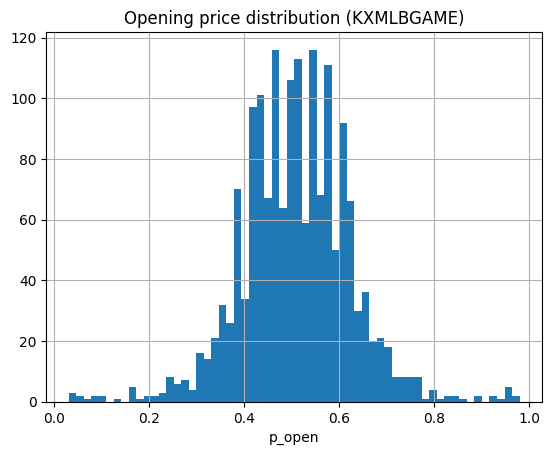

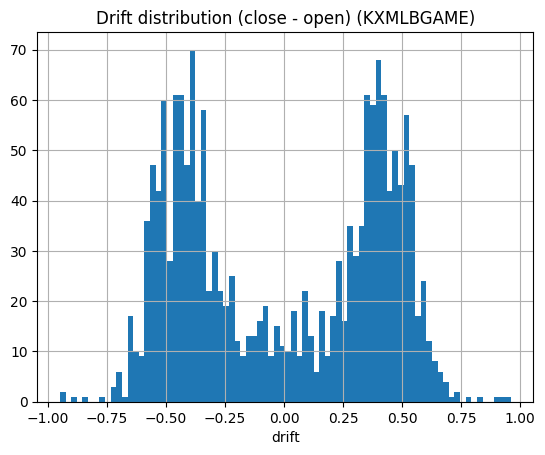

==== Series: KXNBAGAME ====
           p_open     p_close       drift   abs_drift   edge_open  \
count  668.000000  668.000000  668.000000  668.000000  668.000000   
mean     0.512485    0.502156   -0.010329    0.312126   -0.012485   
std      0.212040    0.425929    0.368301    0.195407    0.444235   
min      0.080000    0.010000   -0.890000    0.010000   -0.900000   
25%      0.340000    0.017500   -0.280000    0.160000   -0.400000   
50%      0.510000    0.500000   -0.020000    0.270000   -0.015000   
75%      0.680000    0.990000    0.260000    0.440000    0.370000   
max      0.950000    0.990000    0.870000    0.890000    0.880000   

         edge_close  
count  6.680000e+02  
mean  -2.155689e-03  
std    2.346457e-01  
min   -8.700000e-01  
25%   -1.250000e-02  
50%    3.469447e-18  
75%    1.000000e-02  
max    8.900000e-01  


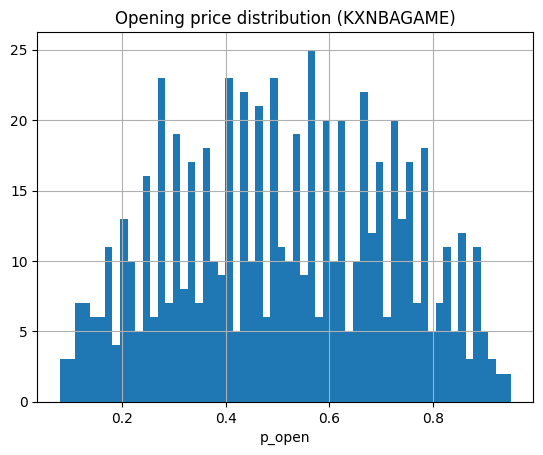

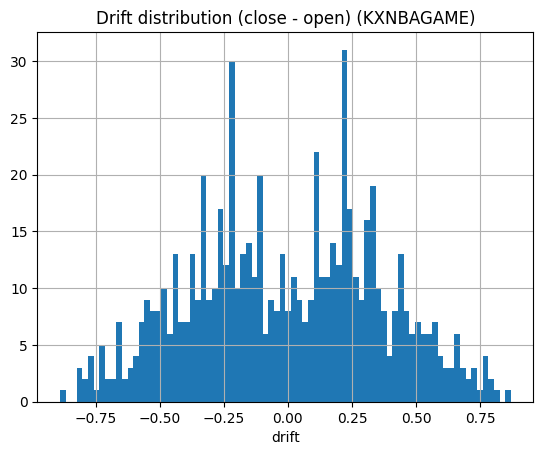

==== Series: KXNFLGAME ====
           p_open     p_close       drift   abs_drift   edge_open  edge_close
count  469.000000  469.000000  469.000000  469.000000  469.000000  469.000000
mean     0.506503    0.500789   -0.005714    0.339531   -0.005437    0.000277
std      0.188108    0.418875    0.383637    0.177995    0.471373    0.274771
min      0.100000    0.010000   -0.810000    0.000000   -0.880000   -0.960000
25%      0.370000    0.030000   -0.330000    0.220000   -0.430000   -0.030000
50%      0.500000    0.510000    0.000000    0.330000    0.080000    0.010000
75%      0.650000    0.970000    0.320000    0.450000    0.420000    0.030000
max      0.920000    0.990000    0.800000    0.810000    0.870000    0.980000


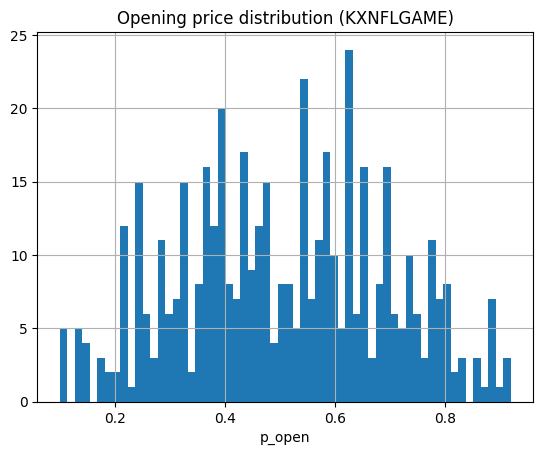

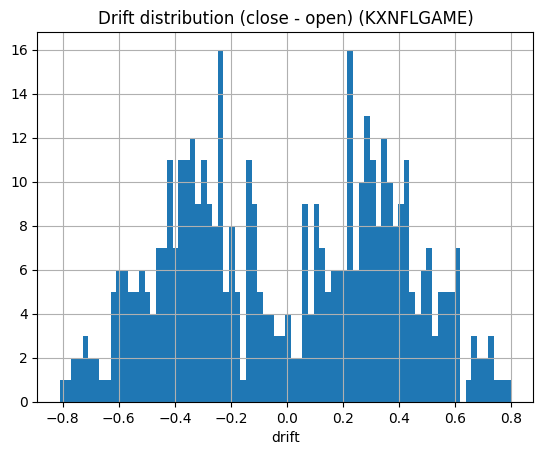

==== Series: KXNHLGAME ====
           p_open     p_close       drift   abs_drift   edge_open  edge_close
count  921.000000  921.000000  921.000000  921.000000  921.000000  921.000000
mean     0.519088    0.506200   -0.012888    0.420619   -0.018545   -0.005657
std      0.127389    0.459656    0.449884    0.159530    0.491447    0.166246
min      0.010000    0.010000   -0.790000    0.000000   -0.800000   -0.840000
25%      0.430000    0.010000   -0.450000    0.350000   -0.490000   -0.010000
50%      0.520000    0.520000    0.000000    0.440000    0.010000    0.010000
75%      0.600000    0.990000    0.430000    0.530000    0.460000    0.010000
max      0.990000    0.990000    0.770000    0.790000    0.780000    0.850000


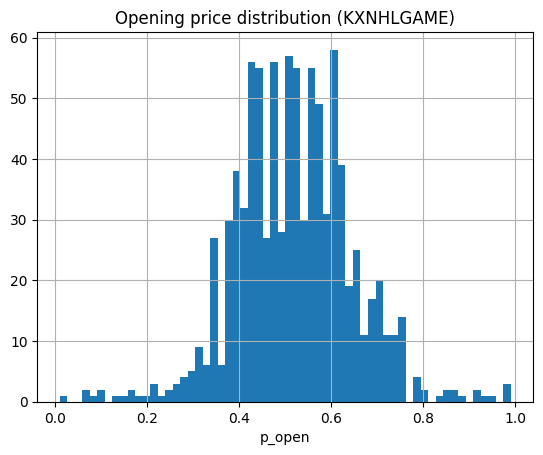

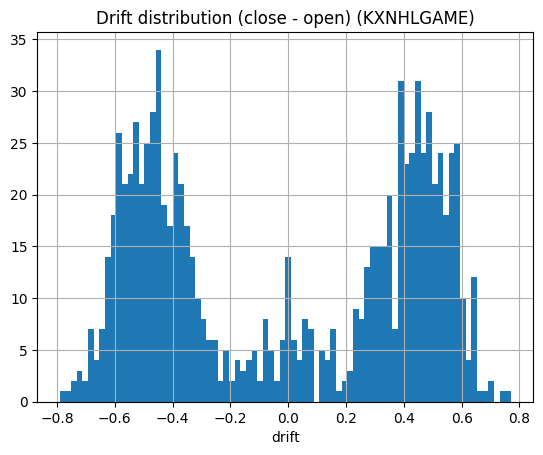

In [24]:

for series, grp in df.groupby("series"):
    print(f"==== Series: {series} ====")
    print(grp[["p_open","p_close","drift","abs_drift","edge_open","edge_close"]].describe())

    plt.figure()
    grp["p_open"].hist(bins=60)
    plt.title(f"Opening price distribution ({series})")
    plt.xlabel("p_open")
    plt.show()

    plt.figure()
    grp["drift"].hist(bins=80)
    plt.title(f"Drift distribution (close - open) ({series})")
    plt.xlabel("drift")
    plt.show()




# Regime 1 — High vs Low Drift days (information-flow regime)

Compute daily mean absolute drift. Define:
- **High drift days**: top 30%
- **Low drift days**: bottom 30%

Then compare:
- Brier(open) vs Brier(close)
- Average drift and underdog upset rate


In [25]:

# Compute regime statistics by series

all_drift_summaries = []

for series, df_s in df.groupby("series"):
    daily = df_s.groupby("day").agg(
        n=("market","size"),
        mean_abs_drift=("abs_drift","mean"),
        mean_drift=("drift","mean"),
        brier_open=("edge_open", lambda x: float(np.mean(np.square(x)))),
        brier_close=("edge_close", lambda x: float(np.mean(np.square(x)))),
        underdog_win_rate=("underdog_win","mean"),
        favorite_rate=("favorite","mean"),
    ).reset_index().sort_values("day")

    q_lo, q_hi = daily["mean_abs_drift"].quantile([0.30, 0.70]).tolist()

    def drift_regime(v):
        if v <= q_lo: return "Low drift"
        if v >= q_hi: return "High drift"
        return "Mid"

    daily["drift_regime"] = daily["mean_abs_drift"].apply(drift_regime)

    drift_summary = daily.groupby("drift_regime").agg(
        days=("day","size"),
        avg_n=("n","mean"),
        mean_abs_drift=("mean_abs_drift","mean"),
        mean_drift=("mean_drift","mean"),
        brier_open=("brier_open","mean"),
        brier_close=("brier_close","mean"),
        underdog_win_rate=("underdog_win_rate","mean"),
        favorite_rate=("favorite_rate","mean"),
    ).reset_index()

    drift_summary["brier_improvement"] = drift_summary["brier_open"] - drift_summary["brier_close"]
    drift_summary["series"] = series
    all_drift_summaries.append(drift_summary)

drift_summary_by_series = pd.concat(all_drift_summaries, ignore_index=True)
drift_summary_by_series


,drift_regime,days,avg_n,mean_abs_drift,mean_drift,brier_open,brier_close,underdog_win_rate,favorite_rate,brier_improvement,series
0,High drift,25,21.400000,0.462134,-0.008178,0.275298,0.016491,0.259564,0.510124,0.258807,KXMLBGAME
1,Low drift,25,17.400000,0.301686,-0.003205,0.209335,0.068512,0.147318,0.506035,0.140822,KXMLBGAME
2,Mid,32,21.812500,0.381896,-0.003940,0.240093,0.041231,0.185063,0.513476,0.198862,KXMLBGAME
3,High drift,15,12.733333,0.409777,-0.007569,0.253385,0.039915,0.187885,0.508120,0.213470,KXNBAGAME
4,Low drift,15,12.933333,0.208379,-0.008305,0.167752,0.105893,0.107328,0.504167,0.061859,KXNBAGAME
5,Mid,20,14.150000,0.314939,-0.014359,0.198005,0.044555,0.150163,0.525160,0.153450,KXNBAGAME
6,High drift,16,6.125000,0.544084,-0.006478,0.372536,0.022307,0.387344,0.500000,0.350230,KXNFLGAME
7,Low drift,16,7.250000,0.182542,-0.003590,0.176282,0.111997,0.125501,0.500000,0.064285,KXNFLGAME
8,Mid,22,11.590909,0.332112,-0.003751,0.196814,0.046842,0.093210,0.484848,0.149973,KXNFLGAME
9,High drift,19,13.894737,0.487179,-0.004587,0.266246,0.005374,0.250804,0.504094,0.260872,KXNHLGAME


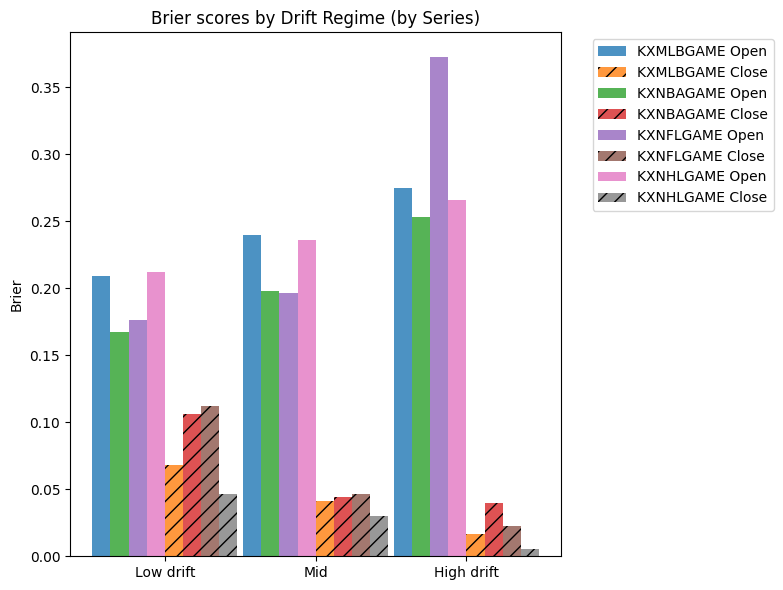

In [26]:

import matplotlib.pyplot as plt

series_list = drift_summary_by_series['series'].unique()
drift_regimes = ["Low drift", "Mid", "High drift"]

fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.12
n_regimes = len(drift_regimes)
n_series = len(series_list)

x = np.arange(n_regimes)

for i, series in enumerate(series_list):
    df_sub = drift_summary_by_series[drift_summary_by_series["series"] == series]
    # Ensure all regimes are present and ordered, else fill with NaN
    df_sub = df_sub.set_index("drift_regime").reindex(drift_regimes)
    ax.bar(
        x + (i - n_series/2)*bar_width + bar_width/2, 
        df_sub["brier_open"], 
        width=bar_width, 
        label=f"{series} Open", 
        alpha=0.8
    )
    ax.bar(
        x + (i - n_series/2)*bar_width + bar_width/2 + bar_width*n_series, 
        df_sub["brier_close"], 
        width=bar_width, 
        label=f"{series} Close", 
        alpha=0.8, 
        hatch="//"
    )


ax.set_xticks(x + bar_width * n_series / 2)
ax.set_xticklabels(drift_regimes)
ax.set_title("Brier scores by Drift Regime (by Series)")
ax.set_ylabel("Brier")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




# Regime 2 — Upset-heavy vs Favorite-dominant days (outcome regime)

Daily underdog win rate is computed using opening price:
- Underdog = p_open < 0.5
- Upset = underdog wins (YES resolves)

Define:
- **Upset-heavy days**: top 30%
- **Favorite-dominant days**: bottom 30%

Compare open vs close accuracy and drift in these regimes.


In [33]:
df

,series,market,close_dt_utc,day,y,p_open,p_close,drift,abs_drift,edge_open,edge_close,favorite,underdog_win,pbin
0,KXNBAGAME,KXNBAGAME-25NOV30HOUUTA-HOU,2025-11-30 22:49:50.356913+00:00,2025-11-30 05:00:00+00:00,1,0.85,0.99,0.14,0.14,0.15,0.01,1,0,"(0.8, 0.9]"
1,KXNBAGAME,KXNBAGAME-25NOV29DENPHX-PHX,2025-11-30 04:29:38.170741+00:00,2025-11-29 05:00:00+00:00,0,0.37,0.04,-0.33,0.33,-0.37,-0.04,0,0,"(0.3, 0.4]"
2,KXNBAGAME,KXNBAGAME-25NOV29DENPHX-DEN,2025-11-30 04:29:38.170741+00:00,2025-11-29 05:00:00+00:00,1,0.68,0.97,0.29,0.29,0.32,0.03,1,0,"(0.6, 0.7]"
3,KXNBAGAME,KXNBAGAME-25NOV29NOPGSW-NOP,2025-11-30 04:29:37.962085+00:00,2025-11-29 05:00:00+00:00,0,0.28,0.01,-0.27,0.27,-0.28,-0.01,0,0,"(0.2, 0.3]"
4,KXNBAGAME,KXNBAGAME-25NOV29NOPGSW-GSW,2025-11-30 04:29:37.962085+00:00,2025-11-29 05:00:00+00:00,1,0.75,0.97,0.22,0.22,0.25,0.03,1,0,"(0.7, 0.8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3721,KXMLBGAME,KXMLBGAME-25JUL31ATLCIN-CIN,2025-08-01 02:34:44.080162+00:00,2025-07-31 04:00:00+00:00,0,0.61,0.60,-0.01,0.01,-0.61,-0.60,1,0,"(0.6, 0.7]"
3722,KXMLBGAME,KXMLBGAME-25JUL31ATLCIN-ATL,2025-08-01 02:34:44.080162+00:00,2025-07-31 04:00:00+00:00,1,0.41,0.43,0.02,0.02,0.59,0.57,0,1,"(0.4, 0.5]"
3723,KXMLBGAME,KXMLBGAME-25AUG01HOUBOS-HOU,2025-08-02 02:03:22.857159+00:00,2025-08-01 04:00:00+00:00,0,0.56,0.01,-0.55,0.55,-0.56,-0.01,1,0,"(0.5, 0.6]"
3724,KXMLBGAME,KXMLBGAME-25JUL31TEXSEA-TEX,2025-08-01 04:24:33.677436+00:00,2025-08-01 04:00:00+00:00,0,0.41,0.01,-0.40,0.40,-0.41,-0.01,0,0,"(0.4, 0.5]"


In [36]:
# Compute upset regime by series using df

def compute_upset_regime_by_series(df, series_col="series"):
    import pandas as pd

    if series_col not in df.columns:
        raise KeyError(f"Column '{series_col}' not found in DataFrame.")
    results = []
    for series, daily_grp in df.groupby(series_col):
        # If there are no rows, skip
        if daily_grp.empty:
            continue
        # If "underdog_win_rate" missing or all null, try to compute if possible or skip
        if "underdog_win_rate" not in daily_grp.columns or daily_grp["underdog_win_rate"].isnull().all():
            # Try to compute if possible
            if "underdog_win" in daily_grp.columns and "p_open" in daily_grp.columns and "day" in daily_grp.columns:
                # Group by day and compute underdog win rate for each day
                daily_rates = (
                    daily_grp
                    .assign(is_underdog=(daily_grp["p_open"] < 0.5).astype(int))
                    .groupby("day")
                    .apply(
                        lambda x: pd.Series({
                            "underdog_win_rate": x.loc[x["is_underdog"] == 1, "underdog_win"].mean() if (x["is_underdog"] == 1).any() else float("nan"),
                            "n": len(x)
                        })
                    )
                    .dropna(subset=["underdog_win_rate"])
                    .reset_index()
                )
                if daily_rates.empty:
                    continue
                group = daily_rates
            else:
                # Not enough information to compute, skip group
                continue
        else:
            group = daily_grp.copy()

        # If the input has less than 3 unique values, skip
        if group["underdog_win_rate"].nunique() < 3:
            continue

        # Calculate quantiles within this series
        quantiles = group["underdog_win_rate"].quantile([0.30, 0.70])
        u_lo = quantiles.loc[0.30]
        u_hi = quantiles.loc[0.70]

        def upset_regime(v):
            if v <= u_lo: return "Favorite-dominant"
            if v >= u_hi: return "Upset-heavy"
            return "Mid"

        group = group.copy()
        group["upset_regime"] = group["underdog_win_rate"].apply(upset_regime)

        cols = group.columns
        upset_summary = group.groupby("upset_regime", observed=True).agg(
            days=("day", "size") if "day" in cols else ("underdog_win_rate", "size"),
            avg_n=("n", "mean") if "n" in cols else ("underdog_win_rate", "size"),
            underdog_win_rate=("underdog_win_rate", "mean"),
            mean_abs_drift=("mean_abs_drift", "mean") if "mean_abs_drift" in cols else ("underdog_win_rate", "mean"),
            brier_open=("brier_open", "mean") if "brier_open" in cols else ("underdog_win_rate", "mean"),
            brier_close=("brier_close", "mean") if "brier_close" in cols else ("underdog_win_rate", "mean"),
            favorite_rate=("favorite_rate", "mean") if "favorite_rate" in cols else ("underdog_win_rate", "mean"),
        ).reset_index()

        # If all brier scores are missing, set improvement to nan
        if "brier_open" in upset_summary and "brier_close" in upset_summary:
            upset_summary["brier_improvement"] = upset_summary["brier_open"] - upset_summary["brier_close"]
        else:
            upset_summary["brier_improvement"] = float("nan")

        upset_summary[series_col] = series
        results.append(upset_summary)

    if not results:
        # Return a DataFrame with column names, so .empty but with meaningful columns
        return pd.DataFrame(columns=[
            "upset_regime", "days", "avg_n", "underdog_win_rate", "mean_abs_drift",
            "brier_open", "brier_close", "favorite_rate", "brier_improvement", series_col
        ])
    return pd.concat(results, ignore_index=True)


upset_summary_by_series = compute_upset_regime_by_series(df)


C:\Users\jmani\AppData\Local\Temp\ipykernel_3488\1532613167.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
C:\Users\jmani\AppData\Local\Temp\ipykernel_3488\1532613167.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
C:\Users\jmani\AppData\Local\Temp\ipykernel_3488\1532613167.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a f

In [37]:
upset_summary_by_series


,upset_regime,days,avg_n,underdog_win_rate,mean_abs_drift,brier_open,brier_close,favorite_rate,brier_improvement,series
0,Favorite-dominant,25,14.240000,0.127345,0.127345,0.127345,0.127345,0.127345,0.0,KXMLBGAME
1,Mid,23,25.956522,0.400136,0.400136,0.400136,0.400136,0.400136,0.0,KXMLBGAME
2,Upset-heavy,34,21.029412,0.657013,0.657013,0.657013,0.657013,0.657013,0.0,KXMLBGAME
3,Favorite-dominant,15,13.066667,0.097672,0.097672,0.097672,0.097672,0.097672,0.0,KXNBAGAME
4,Mid,18,15.333333,0.319224,0.319224,0.319224,0.319224,0.319224,0.0,KXNBAGAME
5,Upset-heavy,17,11.529412,0.527194,0.527194,0.527194,0.527194,0.527194,0.0,KXNBAGAME
6,Favorite-dominant,20,2.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,KXNFLGAME
7,Mid,16,22.250000,0.297356,0.297356,0.297356,0.297356,0.297356,0.0,KXNFLGAME
8,Upset-heavy,17,3.764706,0.932773,0.932773,0.932773,0.932773,0.932773,0.0,KXNFLGAME
9,Favorite-dominant,20,13.500000,0.155644,0.155644,0.155644,0.155644,0.155644,0.0,KXNHLGAME


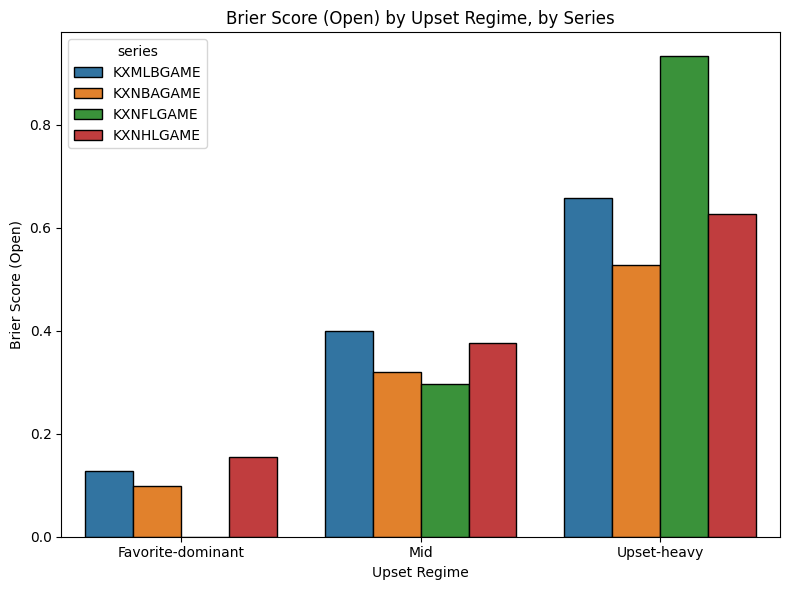

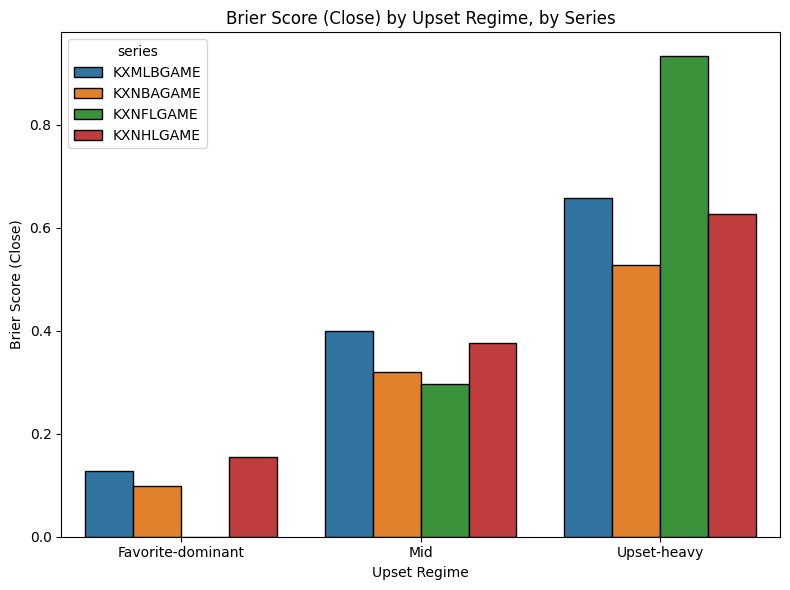

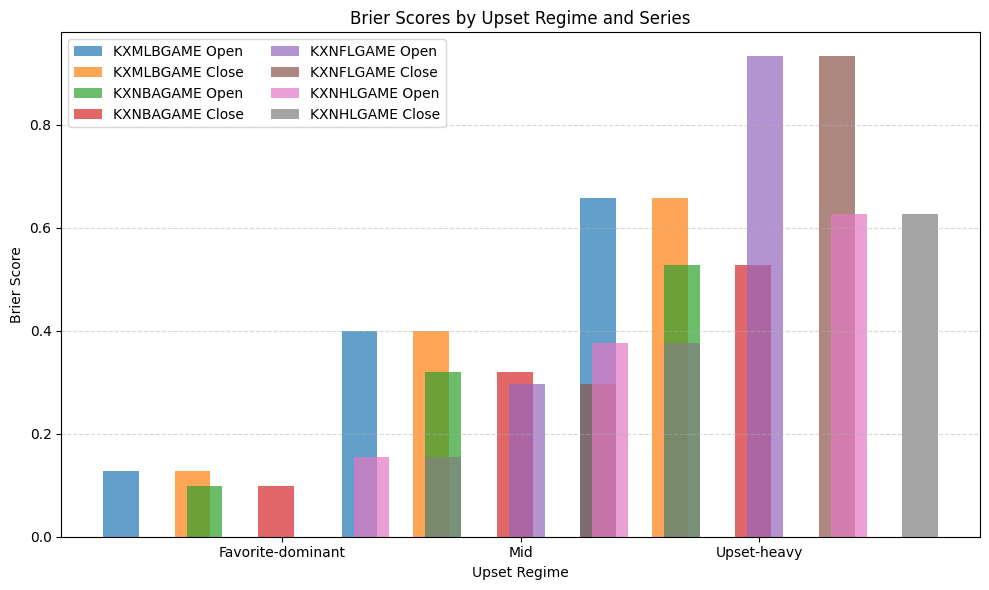

In [40]:
import seaborn as sns

# Ensure series_col is correctly set in the summary DataFrame
series_col = "series" if "series" in upset_summary_by_series.columns else "series"  # fallback for code clarity

# Set plotting style
plt.figure(figsize=(8, 6))

sns.barplot(
    data=upset_summary_by_series,
    x="upset_regime",
    y="brier_open",
    hue=series_col,
    dodge=True,
    edgecolor="black"
)
plt.title("Brier Score (Open) by Upset Regime, by Series")
plt.ylabel("Brier Score (Open)")
plt.xlabel("Upset Regime")
plt.legend(title=series_col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(
    data=upset_summary_by_series,
    x="upset_regime",
    y="brier_close",
    hue=series_col,
    dodge=True,
    edgecolor="black"
)
plt.title("Brier Score (Close) by Upset Regime, by Series")
plt.ylabel("Brier Score (Close)")
plt.xlabel("Upset Regime")
plt.legend(title=series_col)
plt.tight_layout()
plt.show()

# Joint plot: Open vs Close for each series & regime
plt.figure(figsize=(10, 6))
width = 0.35
regimes = upset_summary_by_series["upset_regime"].unique()
serieses = upset_summary_by_series[series_col].unique()
regime_index = {r: i for i, r in enumerate(regimes)}

for s_idx, s in enumerate(serieses):
    series_data = upset_summary_by_series[upset_summary_by_series[series_col] == s]
    x = [regime_index[r] + width*s_idx - width*(len(serieses)-1)/2 for r in series_data["upset_regime"]]
    plt.bar([xi - 0.15 for xi in x], series_data["brier_open"], width=0.15, label=f"{s} Open", alpha=0.7)
    plt.bar([xi + 0.15 for xi in x], series_data["brier_close"], width=0.15, label=f"{s} Close", alpha=0.7)

plt.xticks(range(len(regimes)), regimes)
plt.title("Brier Scores by Upset Regime and Series")
plt.ylabel("Brier Score")
plt.xlabel("Upset Regime")
handles, labels = plt.gca().get_legend_handles_labels()
# Remove duplicate labels
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), ncol=2)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()



## Easy extras (still simple)

### Calibration (opening vs realized)
This is a classic way to diagnose bias.

### Open vs Close improvement by price bucket
Shows whether the market learns more for favorites/underdogs.


C:\Users\jmani\AppData\Local\Temp\ipykernel_3488\3165074948.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket = df.groupby("pbin").agg(


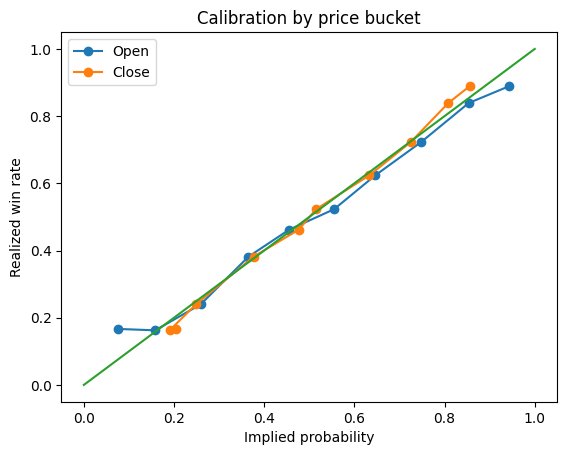

,n,implied_open,implied_close,realized,brier_open,brier_close,mean_abs_drift
pbin,,,,,,,
"(0.0, 0.1]",24,0.075417,0.203333,0.166667,0.152229,0.021958,0.214583
"(0.1, 0.2]",80,0.158375,0.190250,0.162500,0.131364,0.025108,0.220375
"(0.2, 0.3]",196,0.259184,0.248878,0.239796,0.183116,0.056829,0.295816
"(0.3, 0.4]",485,0.364887,0.376330,0.381443,0.235089,0.051466,0.372680
"(0.4, 0.5]",1019,0.455604,0.476693,0.462218,0.248461,0.045357,0.412080
"(0.5, 0.6]",1025,0.555044,0.515132,0.522927,0.250816,0.042887,0.412478
"(0.6, 0.7]",545,0.646477,0.633321,0.623853,0.234742,0.051545,0.370844
"(0.7, 0.8]",238,0.747983,0.724958,0.722689,0.201003,0.054882,0.303361
"(0.8, 0.9]",87,0.853678,0.808391,0.839080,0.131631,0.032468,0.214253


In [41]:

# Calibration by opening-price bucket
bins = np.linspace(0, 1, 11)
df["pbin"] = pd.cut(df["p_open"], bins)

bucket = df.groupby("pbin").agg(
    n=("market","size"),
    implied_open=("p_open","mean"),
    implied_close=("p_close","mean"),
    realized=("y","mean"),
    brier_open=("edge_open", lambda x: float(np.mean(np.square(x)))),
    brier_close=("edge_close", lambda x: float(np.mean(np.square(x)))),
    mean_abs_drift=("abs_drift","mean"),
).dropna()

plt.figure()
plt.plot(bucket["implied_open"], bucket["realized"], marker="o", label="Open")
plt.plot(bucket["implied_close"], bucket["realized"], marker="o", label="Close")
plt.plot([0,1],[0,1])
plt.title("Calibration by price bucket")
plt.xlabel("Implied probability")
plt.ylabel("Realized win rate")
plt.legend()
plt.show()

bucket
